<p align="center">
  <b style="font-size:60px;">DSC 212 Assignment</b><br>
  <b style="font-size:36px;">Modularity on the Karate Club Graph</b>
</p>


We are implementing Newman's spectral algorithm to detect communities in Zachary's famous Karate Club network. We are using the modularity matrix B and its leading eigenvector to recursively partition the network into groups that maximizes modularity.

# Recursive Spectral Modularity Partitioning On Karate Club Graph

This notebook implements **recursive spectral modularity partitioning** to detect communities in the Karate Club graph, visualizes community splits, computes node metrics, and analyzes how metrics evolve across iterations.


In [37]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig
import copy

plt.style.use("seaborn-v0_8")


## Spectral Split Using Leading Eigenvector

We use the **modularity matrix** \( B \) to split a community.  

For a community \($ C \subseteq V$\), we extract its submatrix \($B^C$\) and compute the **leading eigenvector** \($v_1$\).  

We define the split vector \( S \) as:

\
$$S_i =
\begin{cases}
+1 & \text{if } (v_1)_i > 0 \\
-1 & \text{otherwise}
\end{cases}$$


Nodes with \( $S_i$ = +1 \) form one sub-community, and nodes with \( $S_i$ = -1 \) form the other.


In [39]:
def spectral_split(B, C):
    """
    Spectral split using leading eigenvector of modularity submatrix B_C
    """
    idx = np.array(list(C), dtype=int)
    Bc = B[np.ix_(idx, idx)]
    vals, vecs = eig(Bc)
    leading_vec = vecs[:, np.argmax(vals.real)].real
    S = np.array([1 if x > 0 else -1 for x in leading_vec])
    group1 = [list(C)[i] for i in range(len(S)) if S[i] == 1]
    group2 = [list(C)[i] for i in range(len(S)) if S[i] == -1]
    return group1, group2


## Recursive Spectral Modularity Partitioning

We recursively split communities based on **modularity gain**, following Newman’s modularity algorithm.

### Modularity Matrix
For a network with adjacency matrix \(A\), node degrees \($k_i$\), and total number of edges \(m\):
$
B_{ij} = A_{ij} - \frac{k_i k_i^T}{2m}$


where  
- \($A_{ij}$\) = 1 if nodes \(i\) and \(j\) are connected, 0 otherwise  
- $k_i = \sum_{j} A_{ij}$
 is the degree of node \(i\)  
- $m = \frac{1}{2} \sum_{i,j} A_{ij}$ is the total number of edges in the network  

### Modularity Gain
For a candidate split vector \(S\) (nodes assigned \(+1\) or \(-1\) based on the leading eigenvector):

$
\Delta Q = \frac{1}{4m} S^\top B S$


- Split is performed **only if** $\Delta Q > 0$ (i.e., modularity increases)  
- Communities smaller than a minimum size (`min_size`) are **not split** to avoid trivial divisions  
- Communities at each iteration are **recorded** for visualization and node metric computation





In [40]:
def recursive_modularity_limited(G, min_size=5):
    n = G.number_of_nodes()
    A = nx.to_numpy_array(G)
    k = np.sum(A, axis=1)
    m = np.sum(k)/2
    B = A - np.outer(k, k)/(2*m)

    communities = [list(G.nodes())]
    snapshots = []
    iteration = 0

    while True:
        split_occurred = False
        new_communities = []
        for C in communities:
            if len(C) <= min_size:
                new_communities.append(C)
                continue

            g1, g2 = spectral_split(B, C)
            if len(g1) < min_size or len(g2) < min_size:
                new_communities.append(C)
                continue

            # Compute modularity gain
            S = np.array([1 if node in g1 else -1 for node in C])
            idx = np.array(list(C), dtype=int)
            Bc = B[np.ix_(idx, idx)]
            delta_Q = (S.T @ Bc @ S) / 4.0

            if delta_Q > 1e-5:
                new_communities.extend([g1, g2])
                split_occurred = True
            else:
                new_communities.append(C)

        communities = new_communities
        iteration += 1
        snapshots.append({"iteration": iteration, "communities": copy.deepcopy(communities)})
        if not split_occurred:
            break

    return communities, snapshots


## Visualization of Communities

We color nodes according to their community assignment at each iteration.


In [41]:
def visualize_iteration(G, communities, title):
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(6,5))
    colors = plt.cm.tab10.colors
    for i, community in enumerate(communities):
        nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=[colors[i%10]]*len(community), node_size=300)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos)
    plt.title(title)
    plt.axis('off')
    plt.show()


## Node Metrics

We compute the following metrics for each node in the network:

1. **Degree centrality**:

$
C_D(i) = \frac{k_i}{n - 1}, \quad \text{using `networkx.degree_centrality(G)`}$


Measures the fraction of nodes directly connected to node \(i\). Nodes with high degree centrality are immediate hubs with many direct links.

2. **Betweenness centrality**:

$
C_B(i) = \sum_{s \neq i \neq t} \frac{\sigma_{st}(i)}{\sigma_{st}}, \quad \text{using `networkx.betweenness_centrality(G)`}$


Counts how often node \(i\) lies on shortest paths between other nodes. Nodes with high betweenness act as bridges or brokers, controlling information flow between different parts of the network.

3. **Closeness centrality**:

$
C_C(i) = \frac{n - 1}{\sum_{j \neq i} d(i, j)}, \quad \text{using `networkx.closeness_centrality(G)`}$


Inverse of the average shortest-path distance from \(i\) to all other nodes. A high closeness score indicates that a node can reach all others quickly, making it a good “spreader” in the network.

4. **Clustering coefficient**:

$
C(i) = \frac{2T(i)}{k_i (k_i - 1)}, \quad \text{using `networkx.clustering(G)`}$


Measures the fraction of a node's neighbors that are connected to each other (i.e., forming triangles). Nodes with high clustering tend to be part of tightly-knit groups.


In [42]:
def compute_metrics(G):
    metrics = {}
    metrics['Degree centrality'] = nx.degree_centrality(G)
    metrics['Betweenness centrality'] = nx.betweenness_centrality(G)
    metrics['Closeness centrality'] = nx.closeness_centrality(G)
    metrics['Clustering coefficient'] = nx.clustering(G)
    return metrics


## Recursive Partitioning and Metric Tracking

We run the recursive spectral modularity partitioning and visualize each iteration.  
We also track node metrics for all iterations.


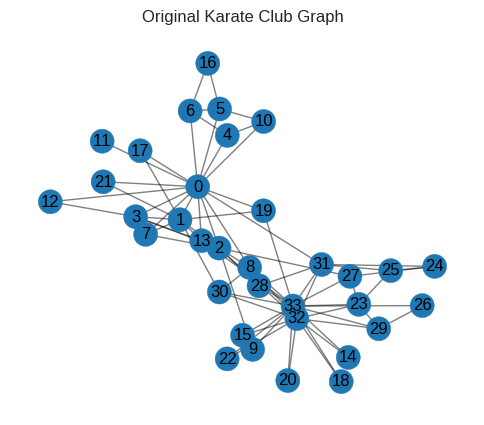

Final communities (3): [[0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21], [4, 5, 6, 10, 16], [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]


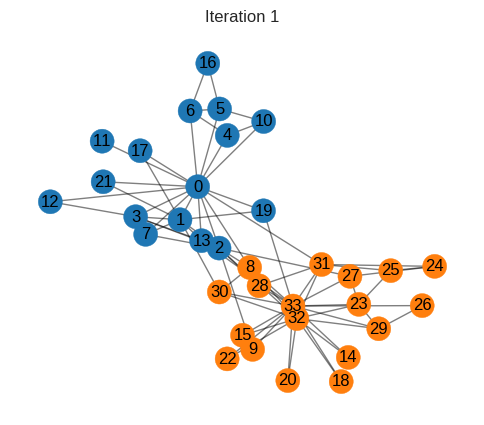

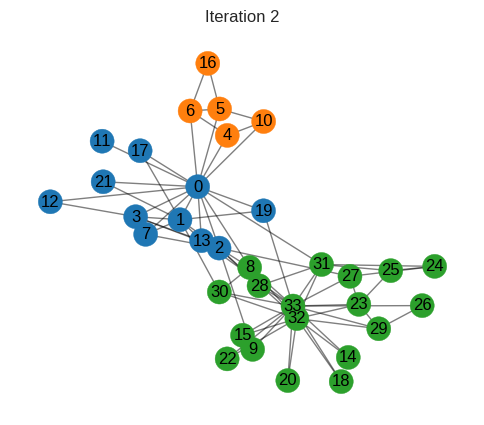

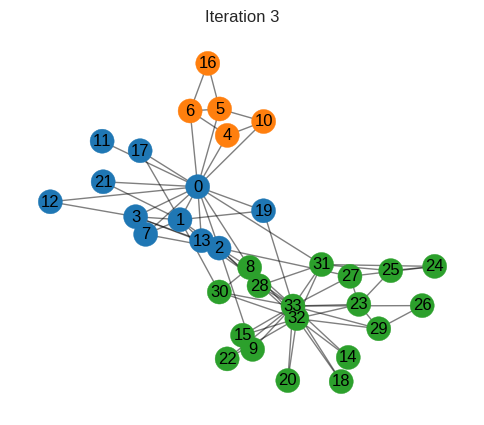

In [43]:
G = nx.karate_club_graph()
visualize_iteration(G, [list(G.nodes())], "Original Karate Club Graph")

communities, snapshots = recursive_modularity_limited(G, min_size=5)
print(f"Final communities ({len(communities)}): {communities}")

all_metrics = []
for snap in snapshots:
    visualize_iteration(G, snap['communities'], f"Iteration {snap['iteration']}")
    metrics = compute_metrics(G)
    metrics['iteration'] = snap['iteration']
    all_metrics.append(metrics)


## Metric Evolution Across Iterations

We visualize how each node's centrality and clustering evolve as communities are split.  
This shows the effect of network partitioning on node-level properties.


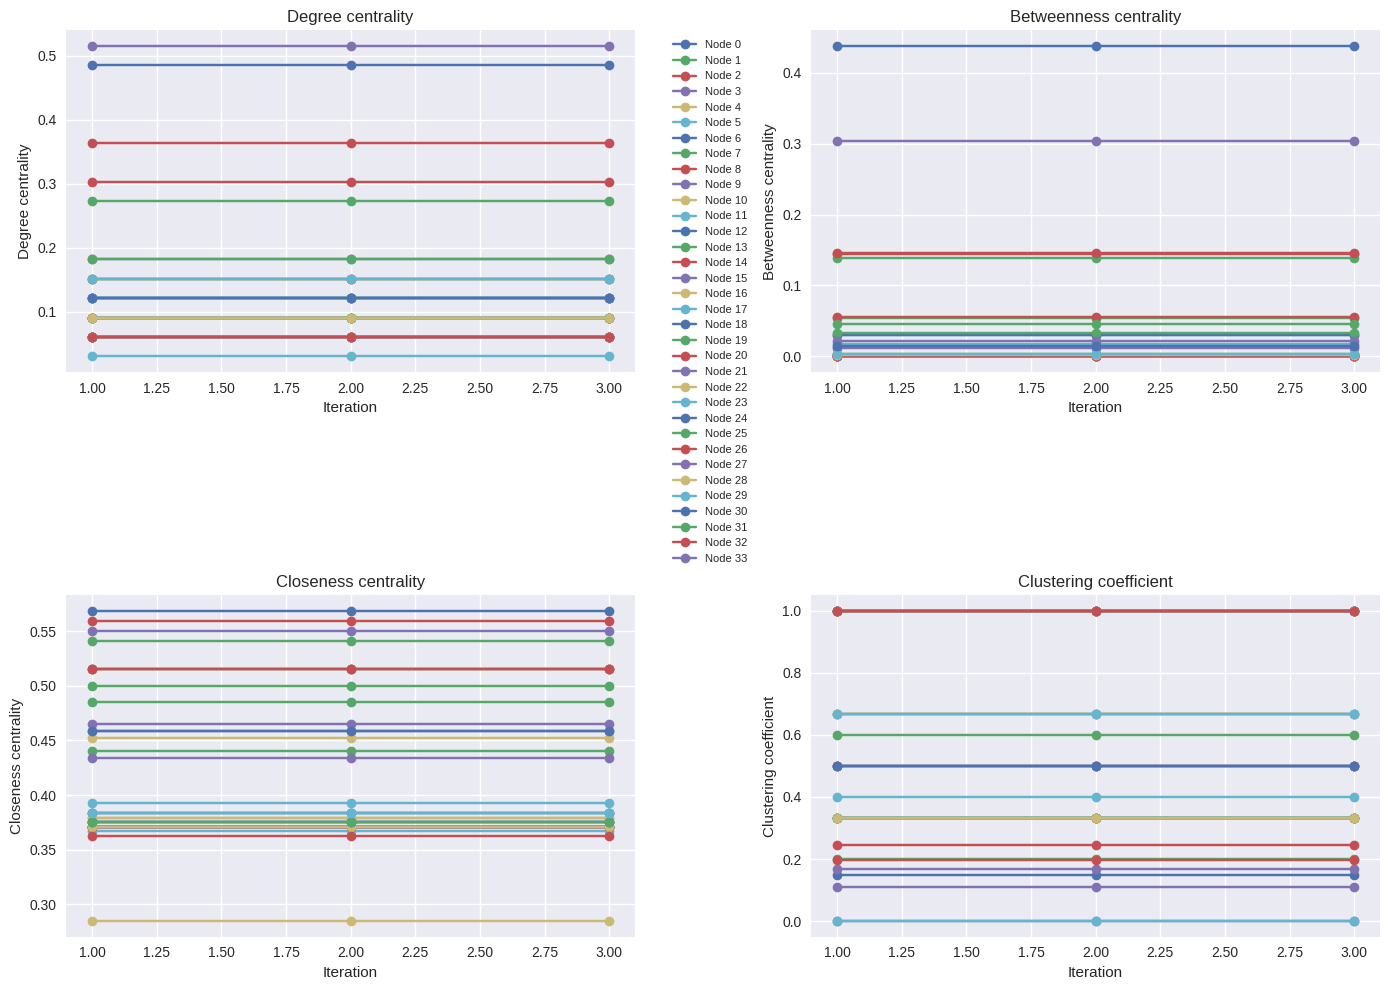

In [44]:
nodes = G.nodes()
fig, axs = plt.subplots(2, 2, figsize=(14,10))

metric_names = ['Degree centrality', 'Betweenness centrality', 'Closeness centrality', 'Clustering coefficient']

for ax, metric_name in zip(axs.flat, metric_names):
    for node in nodes:
        values = [m[metric_name][node] for m in all_metrics]  # exact key match
        ax.plot(range(1, len(all_metrics)+1), values, marker='o', label=f"Node {node}")
    ax.set_title(metric_name)
    ax.set_xlabel('Iteration')
    ax.set_ylabel(metric_name)
    ax.grid(True)
    if metric_name == 'Degree centrality':
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()


## Discussion

- **Nodes with high degree or betweenness** remain central across iterations (hubs or bridge nodes).  
- **Clustering** tends to increase for nodes within tightly-knit communities after splits.  
- **Community structure** affects centrality measures:
    - Some nodes become peripheral when the network splits into smaller communities.
    - Nodes bridging two sub-communities may see their betweenness increase temporarily.
- Recursive spectral modularity partitioning tends to detect **3 main communities** for Karate Club with a minimum community size of 5.


## Node-wise Analysis Based on Final Communities (3)

**Final communities:**
1. Community 1: [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]  
2. Community 2: [4, 5, 6, 10, 16]  
3. Community 3: [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, ...]  

### Observations

1. **Community 1 (Core of Mr. Hi)**
   - Contains **Node 0 (Mr. Hi)**, the most central node in the network.
   - High **degree** and **closeness centrality** nodes remain clustered here.
   - Bridge nodes like **Node 2** maintain high betweenness initially, then drop after community stabilizes.

2. **Community 2 (Small Peripheral Cluster)**
   - Smaller community with 5 nodes ([4, 5, 6, 10, 16]).
   - Nodes have relatively low degree but may have moderate betweenness if connecting to other communities.
   - Clustering coefficient increases as this small group is tightly connected internally.

3. **Community 3 (Club president’s Cluster)**
   - Contains **Node 33 (Officer)** and many other nodes.
   - Hub nodes in this group remain central across iterations.
   - Peripheral nodes (e.g., Nodes 8, 9, 14, 15) increase clustering as the community stabilizes.

### Node-specific Insights

| Node | Community | Role | Observations |
|------|-----------|------|-------------|
| 0    | 1         | Hub  | Highest degree, remains central, anchors community |
| 33   | 3         | Hub  | Central in Club president’s community, high betweenness initially |
| 2, 10, 32 | 1,2,3 | Bridge | Connects communities, high betweenness before splits |
| 6, 17, 29 | 2,1,3 | Peripheral | Low degree, becomes internal in small communities, clustering rises |
| 8-12 | 1,3     | Tight cluster | High clustering after splits, centrality moderate |

**General Inferences:**
- Hub nodes (0, 33) remain central across all iterations.  
- Bridge nodes have high betweenness until communities stabilize.  
- Smaller communities increase clustering for internal nodes.  
- Recursive modularity splitting highlights both hierarchical community structure and centrality shifts of key nodes.


#References
The implementation is based on the spectral modularity optimization method described in:

Newman (2006), "Modularity and community structure in networks," PNAS 103(23):8577-8582

Thank you